## Description:

This file contains:
* data pre-processing (i.e. fill na, scaling, normalizing feature values)
* feature selection (selecting non-correlated features then applying formal feature-selection methods)
* LGBM (feature selected, imbalanced data)
* XGB (feature selected, imbalanced data)
* Balancing dataset via combined sampling

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import joblib

'''Feature Selection'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (SelectFromModel, 
                                       SelectKBest)
from BorutaShap import BorutaShap
import lightgbm as lgb

'''Pre-processing'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import (RandomOverSampler, 
                                    SVMSMOTE)

from sklearn.metrics import (classification_report, 
                             plot_confusion_matrix, 
                             fbeta_score, 
                             precision_score, 
                             recall_score)

from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     StratifiedKFold,
                                    StratifiedShuffleSplit)


'''GCS Utils'''
from gcs_utils import *

import warnings
warnings.filterwarnings('ignore')

SEED=42

In [2]:
# read training, val, test sets

train_df = pd.read_csv("./chk_files/chk_train_set_11302021.csv")

print(train_df.shape)
print(train_df.subscription_status.value_counts())

val_df = pd.read_csv("./chk_files/chk_val_set_11302021.csv")
print(val_df.shape)

test_df = pd.read_csv("./chk_files/chk_test_set_11302021.csv")
print(test_df.shape)

(341849, 619)
0    286993
1     54856
Name: subscription_status, dtype: int64
(73253, 619)
(73254, 619)


In [3]:
val_df.equals(test_df)

False

In [4]:
train_df.tail()

,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,rf_newsletter,...,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top,subscription_status
341844,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
341845,1.0,1.0,28.0,28.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
341846,1.0,1.0,39.5,39.5,1.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
341847,1.0,1.0,95.7,87.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,178.0,0.0,0.0,0.0,0.0,0
341848,1.0,1.0,147.0,147.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


**Treatment 1** - Drop correlated features

In [5]:
# Create correlation matrix of the entire dataframe
corr_matrix = train_df.corr().abs()

# Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(len(to_drop)) # 4 mins

20


In [5]:
to_drop = ['session_pvs_median', 'session_top_median', 't2_auto_type_pvs', 't2_business_pvs', 't2_computing_pvs', 't2_crime_pvs', 
           't2_diseases_and_conditions_pvs', 't2_email_pvs', 't2_family_and_children_movies_pvs', 't2_job_search_pvs', 't2_law_pvs',
           't2_politics_pvs', 't2_real_estate_buying_and_selling_pvs', 't2_travel_type_pvs', 't2_video_game_genres_pvs', 't2_world_movies_pvs', 
           'ps_games_pvs', 'business_hours_pvs', 'non_business_hours_pvs']

train_df.drop(to_drop, axis=1, inplace=True)

print("Whole df shape: ", train_df.shape)

Whole df shape:  (341849, 600)


**Treatment 2** - Feature Select

* Why feature select first?
    * Feature selection using Tree-based models doesnt need scaled/normalized feature values. So, it can be performed before scaling/normalizing values.
    * Improves processing time in production a lot if feature scaling/normalizing needs to be performed only on feature selected columns

In [6]:
# train
X_train = train_df.iloc[:, :-1]
y_train = train_df["subscription_status"]

In [10]:
model = lgb.LGBMRegressor(random_state=SEED)

Feature_Selector = BorutaShap(
    model=model, 
    importance_measure='shap', 
    classification=False  
)

# If no important features are selected, increase the number of trials
    
Feature_Selector.fit(
    X = X_train,
    y = y_train,
    n_trials = 50,
    sample = False,
    # sample_fraction = 0.7, # Sample fraction of original data (row wise) used in calculating feature importance values - gave ERROR "got unexpected sample_fraction arg"
    train_or_test='test',
    normalize=True,
    verbose=True
) 

# 50 trials = 18mins
# 100 trials = 39mins. All 47 same plus two (['hour_23_top', 'monday_top'])

  0%|          | 0/50 [00:00<?, ?it/s]

47 attributes confirmed important: ['rf_organic_social_dark', 'session_top_mean', 'content_views_rate', 'weekend_pvs', 'dos_windows', 'tuesday_top', 'ps_careers_pvs', 'ps_consumer_tech_pvs', 'ps_investing_pvs', 'rf_direct', 'ps_healthcare_pvs', 'business_hours_top', 'wednesday_top', 'dos_android', 'dos_ios', 'pc_business_pvs', 'ct_united_states', 'weekday_top', 'ps_policy_pvs', 't1_business_and_finance_top', 't2_dining_out_pvs', 'bounce_rate', 'pc_innovation_pvs', 'ps_cybersecurity_pvs', 't2_economy_pvs', 'pc_lifestyle_pvs', 'weekend_top', 'ps_personal_finance_pvs', 'session_pvs_mean', 'ps_taxes_pvs', 'rf_newsletter', 'rf_referral', 'non_business_hours_top', 'rf_content_aggregators', 'rf_organic_social_forbes', 'pc_home_pvs', 'rf_organic_search', 'pc_leadership_pvs', 't2_pc_games_pvs', 't1_news_and_politics_pvs', 'pc_billionaires_pvs', 'ct_india', 'dos_macintosh', 't1_business_and_finance_pvs', 't1_medical_health_pvs', 't2_industries_pvs', 't1_movies_pvs']
547 attributes confirmed unim

In [12]:
# Return a list with the selected features

boruta_shap_feats = Feature_Selector.accepted

print(sorted(boruta_shap_feats))

['bounce_rate', 'business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states', 'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows', 'non_business_hours_top', 'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 'pc_lifestyle_pvs', 'ps_careers_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_personal_finance_pvs', 'ps_policy_pvs', 'ps_taxes_pvs', 'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark', 'rf_organic_social_forbes', 'rf_referral', 'session_pvs_mean', 'session_top_mean', 't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_medical_health_pvs', 't1_movies_pvs', 't1_news_and_politics_pvs', 't2_dining_out_pvs', 't2_economy_pvs', 't2_industries_pvs', 't2_pc_games_pvs', 'tuesday_top', 'wednesday_top', 'weekday_top', 'weekend_pvs', 'weekend_top']


In [13]:
# ------ RF + SelectFromModel based feature selection -------

sel = SelectFromModel(
    RandomForestClassifier(n_estimators = 500))

sel.fit(X_train, 
        y_train)

rf_feat= X_train.columns[(sel.get_support())]

print("RF + SelectFromModel features", len(rf_feat))  # 16mins #6.11

RF + SelectFromModel features 60


In [14]:
rf_feat

Index(['session_pvs_mean', 'session_top_mean', 'bounce_rate',
       'content_views_rate', 'rf_content_aggregators', 'rf_direct',
       'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark',
       'rf_organic_social_forbes', 'rf_referral', 'ct_united_states',
       'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows',
       't1_business_and_finance_pvs', 't1_careers_pvs',
       't1_medical_health_pvs', 't1_news_and_politics_pvs',
       't2_industries_pvs', 'pc_billionaires_pvs', 'pc_business_pvs',
       'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs',
       'pc_lifestyle_pvs', 'pc_money_pvs', 'pc_small_business_pvs',
       'ps_careers_pvs', 'ps_cmo_network_pvs', 'ps_entrepreneurs_pvs',
       'ps_forbeswomen_pvs', 'ps_leadership_strategy_pvs',
       't1_business_and_finance_top', 't1_news_and_politics_top',
       'weekend_pvs', 'weekend_top', 'weekday_top', 'business_hours_top',
       'non_business_hours_top', 'friday_top', 'monday_top', 'sunday_top',
 

In [32]:
# excluded dos features

boruta_shap_feats = ['bounce_rate', 'business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states', 
                     'non_business_hours_top', 
                     'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 
                     'pc_lifestyle_pvs', 'ps_careers_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 
                     'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_personal_finance_pvs', 'ps_policy_pvs', 'ps_taxes_pvs', 
                     'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark',
                     'rf_organic_social_forbes', 'rf_referral', 'session_pvs_mean', 'session_top_mean', 
                     't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_medical_health_pvs', 
                     't1_movies_pvs', 't1_news_and_politics_pvs', 't2_dining_out_pvs', 't2_economy_pvs', 
                     't2_industries_pvs', 't2_pc_games_pvs', 'weekend_pvs', 'weekend_top']
len(boruta_shap_feats)

40

In [33]:
# excluded dos features

rf_feat = ['session_pvs_mean', 'session_top_mean', 'bounce_rate',
       'content_views_rate', 'rf_content_aggregators', 'rf_direct',
       'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark',
       'rf_organic_social_forbes', 'rf_referral', 'ct_united_states',
       't1_business_and_finance_pvs', 't1_careers_pvs',
       't1_medical_health_pvs', 't1_news_and_politics_pvs',
       't2_industries_pvs', 'pc_billionaires_pvs', 'pc_business_pvs',
       'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs',
       'pc_lifestyle_pvs', 'pc_money_pvs', 'pc_small_business_pvs',
       'ps_careers_pvs', 'ps_cmo_network_pvs', 'ps_entrepreneurs_pvs',
       'ps_forbeswomen_pvs', 'ps_leadership_strategy_pvs',
       't1_business_and_finance_top', 't1_news_and_politics_top',
       'weekend_pvs', 'weekend_top', 'weekday_top', 'business_hours_top',
       'non_business_hours_top', 'friday_top', 'monday_top', 'sunday_top',
       'thursday_top', 'tuesday_top', 'wednesday_top', 'day_of_mon_7_top',
       'day_of_mon_13_top', 'day_of_mon_21_top', 'day_of_mon_23_top',
       'hour_9_top', 'hour_10_top', 'hour_11_top', 'hour_12_top',
       'hour_13_top', 'hour_14_top', 'hour_15_top', 'hour_16_top',
       'hour_17_top']

len(rf_feat)

56

In [34]:
# WIN - all major categoricals observed during EDA are included as selected features - 

feat_selected = sorted(set(boruta_shap_feats + rf_feat))

In [7]:
# final selection after eye-balling minus device cols

feat_selected = ['bounce_rate', 'business_hours_top', 'non_business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states',
                 'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 
                 'pc_lifestyle_pvs', 'pc_money_pvs', 'pc_small_business_pvs', 'ps_careers_pvs', 'ps_cmo_network_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 
                 'ps_entrepreneurs_pvs', 'ps_forbeswomen_pvs', 'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_leadership_strategy_pvs', 'ps_personal_finance_pvs', 
                 'ps_policy_pvs', 'ps_taxes_pvs', 'session_pvs_mean', 'session_top_mean',
                 'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark', 'rf_organic_social_forbes', 'rf_referral',
                 't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_careers_pvs', 
                 't1_medical_health_pvs', 't1_movies_pvs', 't1_news_and_politics_pvs', 't1_news_and_politics_top', 't2_dining_out_pvs', 't2_economy_pvs', 
                 't2_industries_pvs', 't2_pc_games_pvs','weekday_top', 'weekend_top',  'weekend_pvs', 'weekday_pvs'
                ]

print(len(feat_selected), "\n")

50 



In [9]:
joblib.dump(feat_selected, "chk_feat_selected.joblib")

['chk_feat_selected.joblib']

In [8]:
print("before FS: ", X_train.shape)

# update train sets with fs cols
X_train = X_train[feat_selected] 

print()
print("After FS:", X_train.shape)

before FS:  (341849, 599)

After FS: (341849, 50)


**Treatment 3** - Normalize rows for categorical cols

* Normalize categorical columns
    * For training pipeline, features such as tier 1 sum(pvs) were calculated using users' 10 months of data. In prediction pipeline, sum(pvs) may be summed over 90 days only. This creates difference in distribution in feature tier1 (sum pvs). 
        * To counter - normalize so everything is on same scale. I.e. for a person 20 pvs in busi 50 in games will be normalized to 0.29 in busi and 0.71 in busi<br><br>
        
    * Since we feature selected already, we won't need to not waste time in normalize all 600+ features but only the selected ones
  
 **Note:** - After this treatment columns will be treated as numerical columns - since they were normalized and converted to numbers    

In [9]:
# define col names

t1_pv_cols =        [col for col in X_train.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in X_train.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in X_train.columns if 't2_' in col]
pc_cols =           [col for col in X_train.columns if 'pc_' in col]
ps_cols =           [col for col in X_train.columns if 'ps_' in col]
deviceos_cols =     [col for col in X_train.columns if 'dos_' in col]
referral_cols =     [col for col in X_train.columns if 'rf_' in col]
country_cols =      [col for col in X_train.columns if 'ct_' in col]

wk_pv_cols =        [col for col in X_train.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in X_train.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in X_train.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in X_train.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in X_train.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in X_train.columns if 'hour_' in col] 
minute_cols =       [col for col in X_train.columns if 'minute_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')

categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + minute_cols 
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_top_mean', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

46
4


In [10]:
from sklearn.preprocessing import normalize

# calc % of pvs in respective category instead of using actual sum(pvs) magnitude

def train_normalize_pvs(col_list):
    X_train[col_list] = normalize(X_train[col_list], norm='l1', axis=1)
    
train_normalize_pvs(t1_pv_cols)
train_normalize_pvs(t2_pv_cols)
train_normalize_pvs(pc_cols)
train_normalize_pvs(ps_cols)
train_normalize_pvs(referral_cols)
train_normalize_pvs(country_cols)
train_normalize_pvs(wk_pv_cols)

**Treatment 4** - Scale features

In [12]:
col_list = X_train.columns
len(col_list)

50

In [13]:
# FEATURE SCALING

scaler = StandardScaler()

# fit_transform on training set
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = col_list)

In [16]:
joblib.dump(scaler, "chk_scaler.joblib")

['chk_scaler.joblib']

### Apply treatments/transformations on val and test sets

In [14]:
# val
X_val = val_df.iloc[:, :-1]
y_val = val_df["subscription_status"]

# test
X_test = test_df.iloc[:, :-1]
y_test = test_df["subscription_status"]

In [15]:
len(col_list)

50

In [16]:
# val set

print("before FS: ", X_val.shape)

# ---FEATURE SELECT---
X_val = X_val[feat_selected]

print()
print("After FS:", X_val.shape)

# ---NORMALIZE---
def val_normalize_pvs(col_list):
    X_val[col_list] = normalize(X_val[col_list], norm='l1', axis=1)

val_normalize_pvs(t1_pv_cols)
val_normalize_pvs(t2_pv_cols)
val_normalize_pvs(pc_cols)
val_normalize_pvs(ps_cols)
val_normalize_pvs(referral_cols)
val_normalize_pvs(country_cols)
val_normalize_pvs(wk_pv_cols)

# ---SCALE---
X_val = pd.DataFrame(scaler.transform(X_val), columns = col_list)

before FS:  (73253, 618)

After FS: (73253, 50)


In [19]:
# test set

print("before FS: ", X_test.shape)

# ---FEATURE SELECT---
X_test = X_test[feat_selected]

print()
print("After FS:", X_test.shape)

# ---NORMALIZE---
def test_normalize_pvs(col_list):
    X_test[col_list] = normalize(X_test[col_list], norm='l1', axis=1)

test_normalize_pvs(t1_pv_cols)
test_normalize_pvs(t2_pv_cols)
test_normalize_pvs(pc_cols)
test_normalize_pvs(ps_cols)
test_normalize_pvs(referral_cols)
test_normalize_pvs(country_cols)
test_normalize_pvs(wk_pv_cols)

# ---SCALE---
X_test = pd.DataFrame(scaler.transform(X_test), columns = col_list)

before FS:  (73254, 618)

After FS: (73254, 50)


### Model benchmarking

In [20]:
scoring='f1_weighted'

skf = StratifiedKFold(n_splits = 10, 
                      shuffle=True,
                      random_state = SEED)

sss = StratifiedShuffleSplit(n_splits = 5, 
                             test_size = 0.2, 
                             random_state = SEED) 

* **LGBM**
    * Scaled, Normalized feature values
    * Feature selected
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit

In [21]:
model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=sss,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", round(np.mean(lgbm_base_score), 2))

[0.97821197 0.97794379 0.9772587  0.97818162 0.97707005]
LGBM base score is 0.98


* **LGBM**
    * Scaled, Normalized feature values
    * Feature selected
    * Imbalanced dataset
    * cross-val strategy - StratifiedKFold w/ shuffle=True

In [21]:
model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", round(np.mean(lgbm_base_score), 2))

[0.97754755 0.97660615 0.9775042  0.97697111 0.97775157 0.97737922
 0.97665244 0.97848649 0.97660839 0.97834937]
LGBM base score is 0.98


* Observations:
    * Weighted-f1 gone down from 99 to 98
    * Precision gone down from 96 to 89
    * Recall gone down from 98 to 97
    * Very similar performance on val and test sets
<br><br>
* Pred on val set

                precision    recall  f1-score   support

Non-subscriber       0.99      0.98      0.99     61498
    subscriber       0.89      0.97      0.93     11755

      accuracy                           0.98     73253
     macro avg       0.94      0.97      0.96     73253
  weighted avg       0.98      0.98      0.98     73253



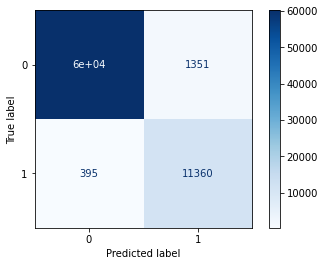

In [22]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

* Pred on test set

                precision    recall  f1-score   support

Non-subscriber       0.99      0.98      0.99     61499
    subscriber       0.90      0.97      0.93     11755

      accuracy                           0.98     73254
     macro avg       0.95      0.97      0.96     73254
  weighted avg       0.98      0.98      0.98     73254



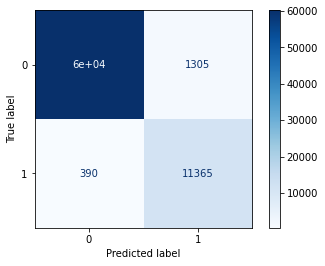

In [23]:
y_test_pred = model.predict(X_test)

print(classification_report(y_test, 
                            y_test_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_test, 
                      y_true=y_test, 
                      cmap='Blues'
                     )

* **Precision** - imp if we dont want a lot of false positives
* **Recall** - imp if we dont want to miss out on subscribers
    * We'll give a bit more importance to recall

In [24]:
# calculate the f2-measure

p = precision_score(y_val, 
                    y_pred)

r = recall_score(y_val, 
                 y_pred)

f = fbeta_score(y_val, 
                y_pred, 
                beta=2.0) # beta = 2 lowers the importance of precision and increase the importance of recall.

print('Result: precision=%.3f, recall=%.3f, f2-beta=%.3f' % (p, r, f))

Result: precision=0.894, recall=0.966, f2-beta=0.951


* XGB Observations:
    * f1 for subscribers gone down from 98 to 95.
    * Overall f1-weighted gone down from 99 to 98

[19:43:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                precision    recall  f1-score   support

non_subscriber       0.99      0.99      0.99     61498
    subscriber       0.95      0.95      0.95     11755

      accuracy                           0.98     73253
     macro avg       0.97      0.97      0.97     73253
  weighted avg       0.98      0.98      0.98     73253



<AxesSubplot:>

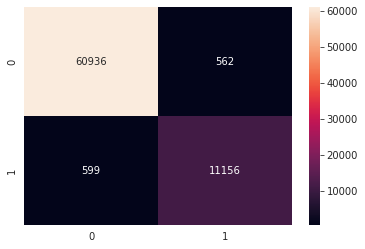

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
sns.set_style('darkgrid')

# set scale_pos_weight, max_delta_step because dataset is imbalanced 

xgb_imb = XGBClassifier(max_delta_step = 1,  
                        random_state=SEED, 
                        scale_pos_weight=2)

xgb_imb.fit(X_train, y_train)

xgb_imb_pred = xgb_imb.predict(X_val)

print(classification_report(y_val, xgb_imb_pred, target_names = ['non_subscriber', 'subscriber']))

# Whats going on with xgb

sns.heatmap(confusion_matrix(y_val, xgb_imb_pred), annot=True, fmt='g')

**Treatment 5** - Sampling for balancing dataset

In [39]:
print("Distribution in train set:")
print(y_train.value_counts())

Distribution in train set:
0    286993
1     54856
Name: subscription_status, dtype: int64


In [40]:
print("Distribution in val set:")
print(y_val.value_counts())

Distribution in val set:
0    61498
1    11755
Name: subscription_status, dtype: int64


In [41]:
print("Distribution in test set:")
print(y_test.value_counts())

Distribution in test set:
0    61499
1    11755
Name: subscription_status, dtype: int64


* over then under - hybrid sampling

In [44]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [45]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.9) 

# first performing oversampling on minority class
X_over, y_over = over.fit_resample(X_train, y_train)

y_over = pd.Series(y_over)
print("Oversampled \n", y_over.value_counts())

# now combine undersampling 
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)

Oversampled 
 0    286993
1    143496
Name: subscription_status, dtype: int64


In [46]:
# convert back to dataframe
Xtrain_combo = pd.DataFrame(X_combined_sampling, columns = X_train.columns)
ytrain_combo = pd.Series(y_combined_sampling)

# name the series
ytrain_combo.name = "subscription_status"

print("After Combined Sampling - Distribution in train set::")

print(ytrain_combo.value_counts())

print(ytrain_combo.value_counts(normalize=True))

After Combined Sampling - Distribution in train set::
0    159440
1    143496
Name: subscription_status, dtype: int64
0   0.5
1   0.5
Name: subscription_status, dtype: float64


In [52]:
print(Xtrain_combo.shape, X_val.shape, X_test.shape)

print("Distribution in val set:")

# distribution untouched

print(y_val.value_counts())

print("Distribution in test set:")

# distribution untouched

print(y_test.value_counts())

(302936, 50) (73253, 50) (73254, 50)
Distribution in val set:
0    61498
1    11755
Name: subscription_status, dtype: int64
Distribution in test set:
0    61499
1    11755
Name: subscription_status, dtype: int64


In [53]:
train_transformed = Xtrain_combo.join(ytrain_combo)
val_transformed = X_val.join(y_val)
test_transformed = X_test.join(y_test)

In [57]:
train_transformed.to_csv("./chk_files/chk_train_transformed_12012021.csv", index=False)

val_transformed.to_csv("./chk_files/chk_val_transformed_12012021.csv", index=False)

test_transformed.to_csv("./chk_files/chk_test_transformed_12012021.csv", index=False)

* Feature selected + including device columns

In [20]:
model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", round(np.mean(lgbm_base_score), 2))

[0.98945667 0.98921358 0.98997021 0.99003474 0.99008862 0.99000888
 0.98946712 0.99066462 0.9897435  0.99093546]
LGBM base score is 0.99


* Pred on val set

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61498
    subscriber       0.95      0.98      0.97     11755

      accuracy                           0.99     73253
     macro avg       0.97      0.99      0.98     73253
  weighted avg       0.99      0.99      0.99     73253



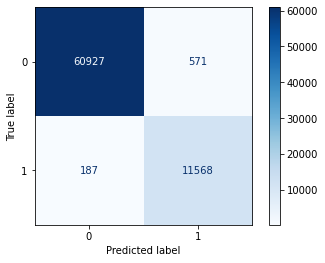

In [21]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

* Pred on test set

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61499
    subscriber       0.96      0.98      0.97     11755

      accuracy                           0.99     73254
     macro avg       0.98      0.99      0.98     73254
  weighted avg       0.99      0.99      0.99     73254



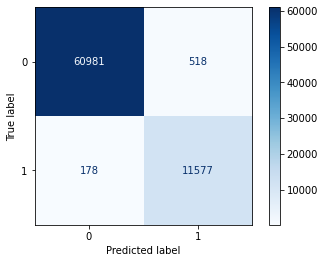

In [22]:
y_test_pred = model.predict(X_test)

print(classification_report(y_test, 
                            y_test_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_test, 
                      y_true=y_test, 
                      cmap='Blues'
                     )